In [1]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy


## Loading the Dataset

In [2]:
import math, re, os
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import requests
import json
print(tf.__version__)

2.9.2


In [3]:
train_ds = tfds.load('oxford_flowers102', split='train', shuffle_files=True)
test_ds = tfds.load('oxford_flowers102', split='test', shuffle_files=True)
val_ds = tfds.load('oxford_flowers102', split='validation', shuffle_files=True)
print(train_ds)
print(val_ds)
print(test_ds)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteNJHX86/oxford_flowers102-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteNJHX86/oxford_flowers102-test.tfrecord*...: …

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteNJHX86/oxford_flowers102-validation.tfrecord…

Dataset oxford_flowers102 downloaded and prepared to ~/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [4]:
dataset, dataset_info = tfds.load('oxford_flowers102', with_info=True, as_supervised=True)
# print shapes of 3 firs images
for feature, label in dataset['train'].take(5):
    print(feature.shape)

(500, 667, 3)
(500, 666, 3)
(670, 500, 3)
(500, 505, 3)
(500, 672, 3)


In [5]:
# Print out dataset info
print(f"Number of training data points: {dataset_info.splits['train'].num_examples}")
print(f"Number of testing data points: {dataset_info.splits['test'].num_examples}")
print(f"Number of validation data points: {dataset_info.splits['validation'].num_examples}")
no_classes = dataset_info.features['label'].num_classes
print(f"number of classes: {no_classes}")

Number of training data points: 1020
Number of testing data points: 6149
Number of validation data points: 1020
number of classes: 102


In [6]:
# Scraping the number label to actual names of the flowers
file_location='https://github.com/CheloGE/ML-tensorflow-Image_classifier-oxford_flowers102/blob/master/label_map.json?raw=1'
r = requests.get(file_location, stream=True)
class_names=json.loads(r.content.decode('utf-8'))
class_names = {int(k):v for k,v in class_names.items()}

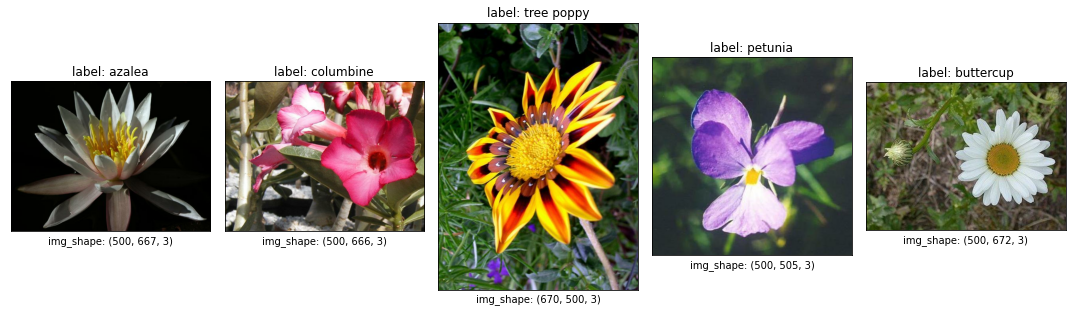

In [7]:
fig = plt.figure(figsize=(15,15))
i=0
for image, label in dataset['train'].take(5):
    ax = fig.add_subplot(1,5,i+1)
    ax.set_xticks([])
    ax.set_yticks([]) 
    plt.imshow(image)
    plt.title(f"label: {class_names[label.numpy()]}")
    plt.xlabel(f"img_shape: {image.shape}")
    i=i+1;
fig.tight_layout()

## AUGMENTATION

In [8]:
IMG_SIZE=224

size = (IMG_SIZE, IMG_SIZE)
ds_train = train_ds.map(lambda vals: (tf.image.resize(vals["image"], size), vals["label"]))
ds_val = val_ds.map(lambda vals: (tf.image.resize(vals["image"], size), vals["label"]))
ds_test = test_ds.map(lambda vals: (tf.image.resize(vals["image"], size), vals["label"]))

In [9]:
IMG_SIZE = 224

img_processing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)
])

img_augmentation = tf.keras.Sequential([
          tf.keras.layers.RandomFlip("horizontal"),
          tf.keras.layers.RandomRotation(factor=0.2),
          tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.3), width_factor=(-0.2,-0.3)),
          tf.keras.layers.RandomBrightness((-0.2,0.2), value_range=[0,1])],
        name='img_augmentation'
        )

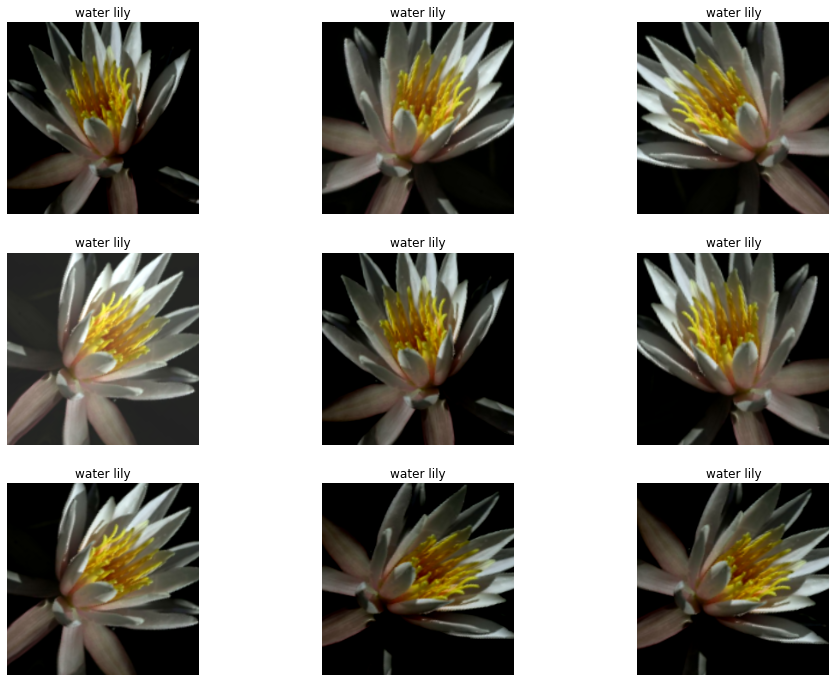

In [10]:
plt.figure(figsize=(16,12))
for vals in train_ds.take(1):
    image=vals['image']
    label=vals['label']
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(img_processing(image))
        plt.imshow(aug_img.numpy())
        plt.title("{}".format(class_names[label.numpy()+1]))
        plt.axis("off")

In [11]:
img_augmentation.summary()

Model: "img_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (224, 224, 3)             0         
                                                                 
 random_rotation (RandomRota  (224, 224, 3)            0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (224, 224, 3)             0         
                                                                 
 random_brightness (RandomBr  (224, 224, 3)            0         
 ightness)                                                       
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


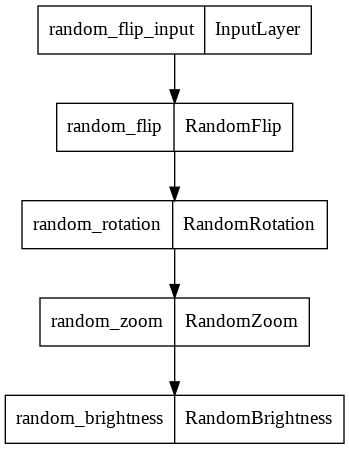

In [12]:
tf.keras.utils.plot_model(img_augmentation)
  

## PREPROCESSING

In [13]:
IMG_SIZE=224

def image_resize(image,size=(IMG_SIZE,IMG_SIZE)):
    return tf.image.resize(image, size)

In [14]:
def encoding(labels, no_classes=102):
    return tf.one_hot(labels, no_classes)

In [15]:
def normalalization(image,a=0,b=1,minPix=[0], maxPix=[255]):
    a = tf.constant([a], dtype=tf.float32)
    b = tf.constant([b], dtype=tf.float32)
    min_pixel = tf.constant(minPix, dtype=tf.float32)
    max_pixel = tf.constant(maxPix, dtype=tf.float32)

    return a + (((image - min_pixel)*(b - a) )/(max_pixel - min_pixel))

In [16]:
def preprocess_data(vals,encode=True):
    # print(vals)

    # print(vals['image'])
    features = img_processing(vals['image'])
    if(encode):
      labels = encoding(vals['label'])
    else:
      labels=tf.cast(vals['label'], tf.int32)
    return features, labels

In [17]:
def preprocess_data_train(vals,encode=True):
    features = img_augmentation(img_processing(vals['image']))

    if(encode):
      labels = encoding(vals['label'])
    else:
      labels=tf.cast(vals['label'], tf.int32)
      
    return features, labels

In [18]:
# AUTO = tf.data.experimental.AUTOTUNE
# buffer_size=2048
# batch_size=32
# processed_train_ds = train_ds.map(lambda x: preprocess_data_train(x,encode=False)).repeat().shuffle(buffer_size).batch(batch_size).prefetch(AUTO)
# processed_val_ds = val_ds.map(lambda x: preprocess_data(x,encode=False)).batch(batch_size).prefetch(AUTO)
# processed_test_ds = test_ds.map(lambda x: preprocess_data(x,encode=False)).batch(batch_size).prefetch(AUTO)

In [19]:
buffer_size=2048
batch_size=32
processed_train_ds = train_ds.repeat(5).map(lambda x : preprocess_data_train(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
processed_val_ds = val_ds.map(lambda x: preprocess_data(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
processed_test_ds = test_ds.map(lambda x: preprocess_data(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

In [20]:
NUM_TRAINING_IMAGES = dataset_info.splits['train'].num_examples
NUM_VALIDATION_IMAGES = dataset_info.splits['validation'].num_examples
NUM_TEST_IMAGES = dataset_info.splits['test'].num_examples
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // batch_size
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 1020 training images, 1020 validation images, 6149 unlabeled test images


In [21]:
print("Training data shapes:")
for image, label in processed_train_ds.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Training data label examples:", label.numpy())
print("Validation data shapes:")
for image, label in processed_test_ds.take(3):
    print(image.numpy().shape, label.numpy().shape)
print("Validation data label examples:", label.numpy())
print("Test data shapes:")
for image, idnum in processed_val_ds.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
print("Test data IDs:", idnum.numpy())

Training data shapes:
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
Training data label examples: [ 10  28   8  41  55  83  51  79  21  64  16  24   5  90  11  86  94 100
  63  89  87  11  50  12   1  74  73  88  91  78  96  10]
Validation data shapes:
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
Validation data label examples: [ 51   0  22  47  47  80  64  76  93  48  21  46  17  37  81  35  94  81
  96  48  55  69  63  32  27  77   1  51  72 100  77  10]
Test data shapes:
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
Test data IDs: [ 92  72 101  15  26  32   2  25  95  99  31  12  84   9   7  14  40  66
  79  97  49 100  21  14   9   5  55  90  29  28  69  84]


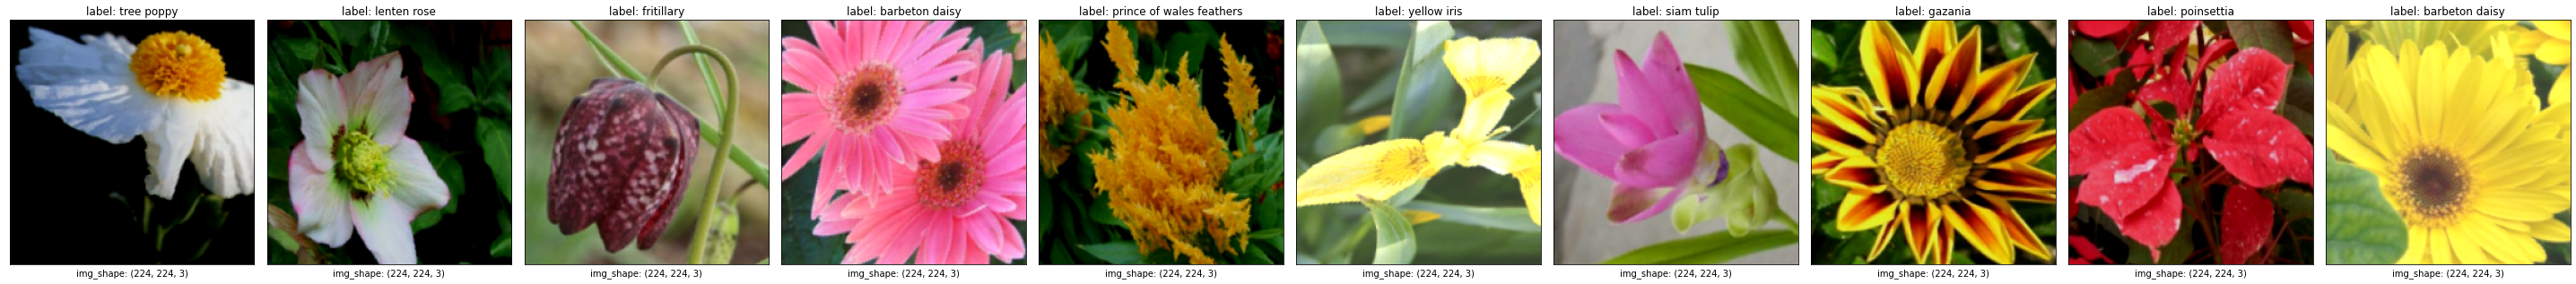

In [22]:
# Afteer preprocessing
fig = plt.figure(figsize=(40,40))
i=0
for j,k in processed_train_ds.take(1):
  for image, label in zip(j,k):
      if(i>=10):
        break
      ax = fig.add_subplot(1,10,i+1)
      ax.set_xticks([])
      ax.set_yticks([]) 
      plt.imshow(image)
      # plt.title(f"label: {class_names[np.where(label.numpy() == 1)[0][0]+1]}")
      plt.title(f"label: {class_names[label.numpy()+1]}")

      plt.xlabel(f"img_shape: {image.shape}")
      i=i+1;
  fig.tight_layout()

# Models

## WITH AUGMENTATION

### DenseNet

Learning rate schedule: 0.0001 to 0.0005 to 0.0001


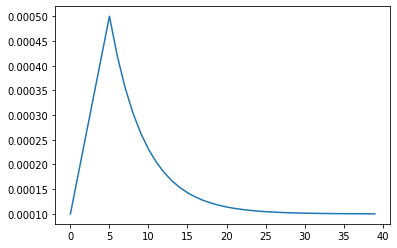

In [38]:
LR_START = 0.0001
LR_MAX = 0.0005 
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 40
STEPS_PER_EPOCH =160
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3, verbose=1, mode='auto', restore_best_weights=True,min_delta=0.001)

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [39]:
# Training only the last layer
pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,
                    input_shape=[224,224, 3])
pretrained_model.trainable = False # False = transfer learning, True = fine-tuning

densenet = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(no_classes, activation='softmax')
])
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
densenet.compile(optimizer=adam,loss = 'sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
densenet.summary()
EPOCHS=60
history_densenet=densenet.fit(processed_train_ds,epochs=EPOCHS, callbacks=[early_stopping,lr_callback], validation_data=processed_val_ds)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_2   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 102)               195942    
                                                                 
Total params: 18,517,926
Trainable params: 195,942
Non-trainable params: 18,321,984
_________________________________________________________________

Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/60
160/160 [==============================] - 84s 351ms/step - loss: 4.4677 - sparse_categorical_accuracy: 0.0561 - val_loss: 4.1692 - val_sparse_categorical_acc

In [ ]:
results = densenet.evaluate(processed_test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

193/193 [==============================] - 29s 151ms/step - loss: 0.4232 - sparse_categorical_accuracy: 0.9005
test loss, test acc: [0.4231632351875305, 0.9004716277122498]


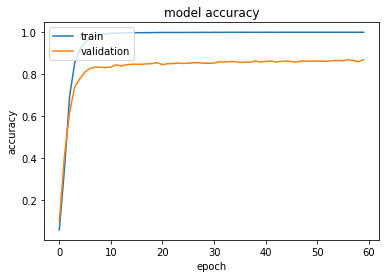

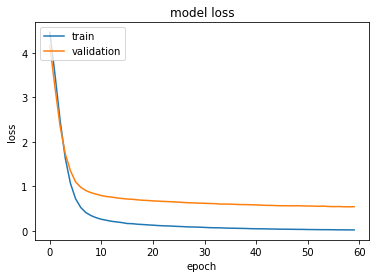

In [40]:
# list all data in history
# summarize history for accuracy
plt.plot(history_densenet.history['sparse_categorical_accuracy'])
plt.plot(history_densenet.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_densenet.history['loss'])
plt.plot(history_densenet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
densenet.save_weights('densenet.hdf5')

In [33]:
# DENSENET
# pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,
#                     input_shape=[224,224, 3])
# Fine-tuning
#pretrained_model.trainable = True # False = transfer learning, True = fine-tuning
for layer in densenet.layers:
    if not isinstance(tf.keras.layers, tf.keras.layers.BatchNormalization):
            layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
densenet.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

  
densenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 102)               195942    
                                                                 
Total params: 18,517,926
Trainable params: 18,288,870
Non-trainable params: 229,056
_________________________________________________________________


In [36]:
# Training all layers
EPOCHS=40
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = densenet.fit(processed_train_ds, epochs=EPOCHS, callbacks=[early_stopping], validation_data=processed_val_ds)

Epoch 1/40
160/160 [==============================] - 131s 705ms/step - loss: 0.0203 - accuracy: 0.9988 - val_loss: 1.2835 - val_accuracy: 0.7147
Epoch 2/40
160/160 [==============================] - 131s 706ms/step - loss: 0.0148 - accuracy: 0.9998 - val_loss: 1.5529 - val_accuracy: 0.6549
Epoch 3/40
160/160 [==============================] - 130s 703ms/step - loss: 0.0117 - accuracy: 0.9994 - val_loss: 1.6224 - val_accuracy: 0.6382
Epoch 4/40
160/160 [==============================] - 131s 708ms/step - loss: 0.0092 - accuracy: 0.9996 - val_loss: 1.5666 - val_accuracy: 0.6569


In [ ]:
results = densenet.evaluate(processed_test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

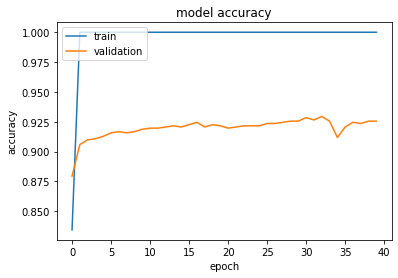

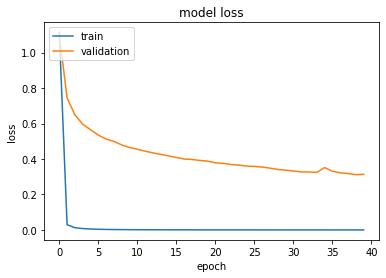

In [97]:
# list all data in history
# summarize history for accuracy
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [91]:
# Show the MAX_PREDS highest scoring labels:
MAX_PREDS = 5
# Do not show labels with lower score than this:
MIN_SCORE = 0.2 

def show_preds(logits, image, correct_flowers_label=None):

  if len(logits.shape) > 1:
    logits = tf.reshape(logits, [-1])

  fig, axes = plt.subplots(1, 2, figsize=(7, 4), squeeze=False)

  ax1, ax2 = axes[0]

  ax1.axis('off')
  ax1.imshow(image)
  if correct_flowers_label is not None:
    ax1.set_title(class_names[correct_flowers_label+1])
  classes = []
  scores = []
  logits_max = np.max(logits)
  #print(sum(logits))
  softmax_denominator = np.sum(np.exp(logits - logits_max))
  scores= np.sort(tf.reshape(logits, [-1]))[-MAX_PREDS::][::-1]*100
  #print(scores)
  for index, j in enumerate(np.argsort(logits)[-MAX_PREDS::][::-1]):
    #score = 1.0/(1.0 + np.exp(-logits[j]))
    
    #if score < MIN_SCORE: break
    # predicting in tf_flowers label space
    classes.append(class_names[j+1])
    #scores.append(np.exp(logits[j] - logits_max)/softmax_denominator*100)
  #print(scores)
  ax2.barh(np.arange(len(scores)) + 0.1, scores)
  ax2.set_xlim(0, 100)
  ax2.set_yticks(np.arange(len(scores)))
  ax2.yaxis.set_ticks_position('right')
  ax2.set_yticklabels(classes, rotation=0, fontsize=14)
  ax2.invert_xaxis()
  ax2.invert_yaxis()
  ax2.set_xlabel('Prediction probabilities', fontsize=11)

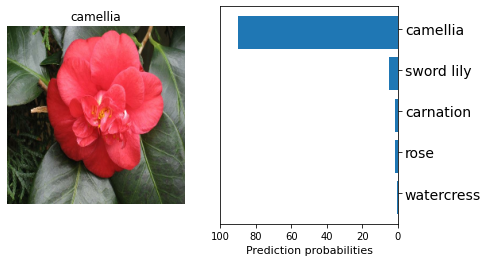

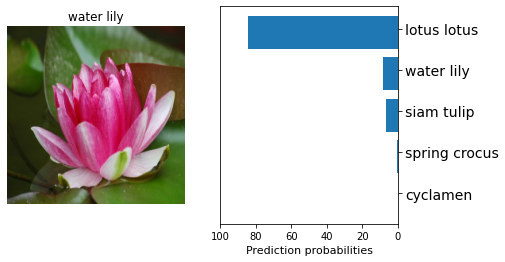

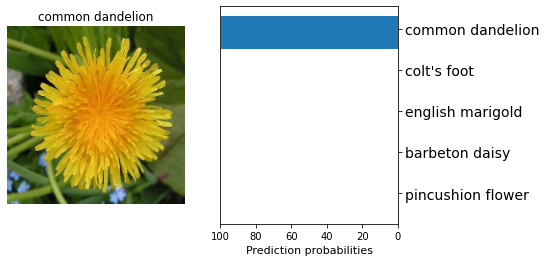

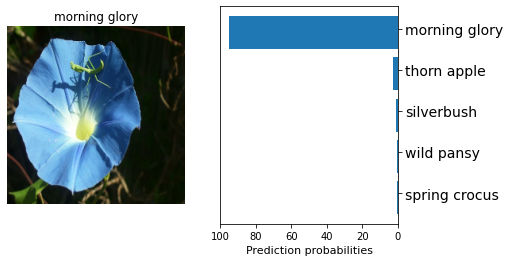

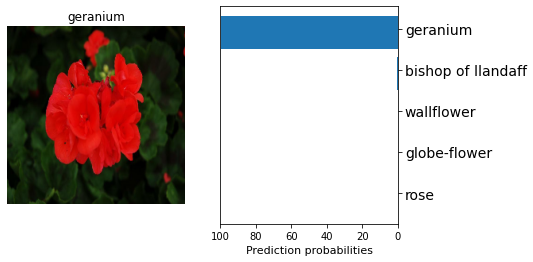

In [92]:
# few examples for prediction on test dataset
for image,label in processed_test_ds.take(1):
  logits = densenet(image)
  for i,j,k in zip(image[:5],label[:5],logits[:5]):
    #print(k)
    #  image and predictions
    show_preds(k, i, correct_flowers_label=j.numpy())

In [ ]:
# predict probabilities for test set
yhat_probs = densenet.predict(processed_test_ds, verbose=1)
# predict crisp classes for test set
yhat_classes = np.argsort(yhat_probs)[:,-1]

193/193 [==============================] - 26s 135ms/step


In [ ]:
ytest=[]
y_pred=[]
for image, label in processed_test_ds:
    label = label.numpy()
    ytest.append(label)
    y_pred.append(np.argsort(densenet.predict(image,verbose=0))[:,-1])

ytest=np.concatenate( ytest, axis=0 )
y_pred=np.concatenate( y_pred, axis=0 )


In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(ytest, y_pred)

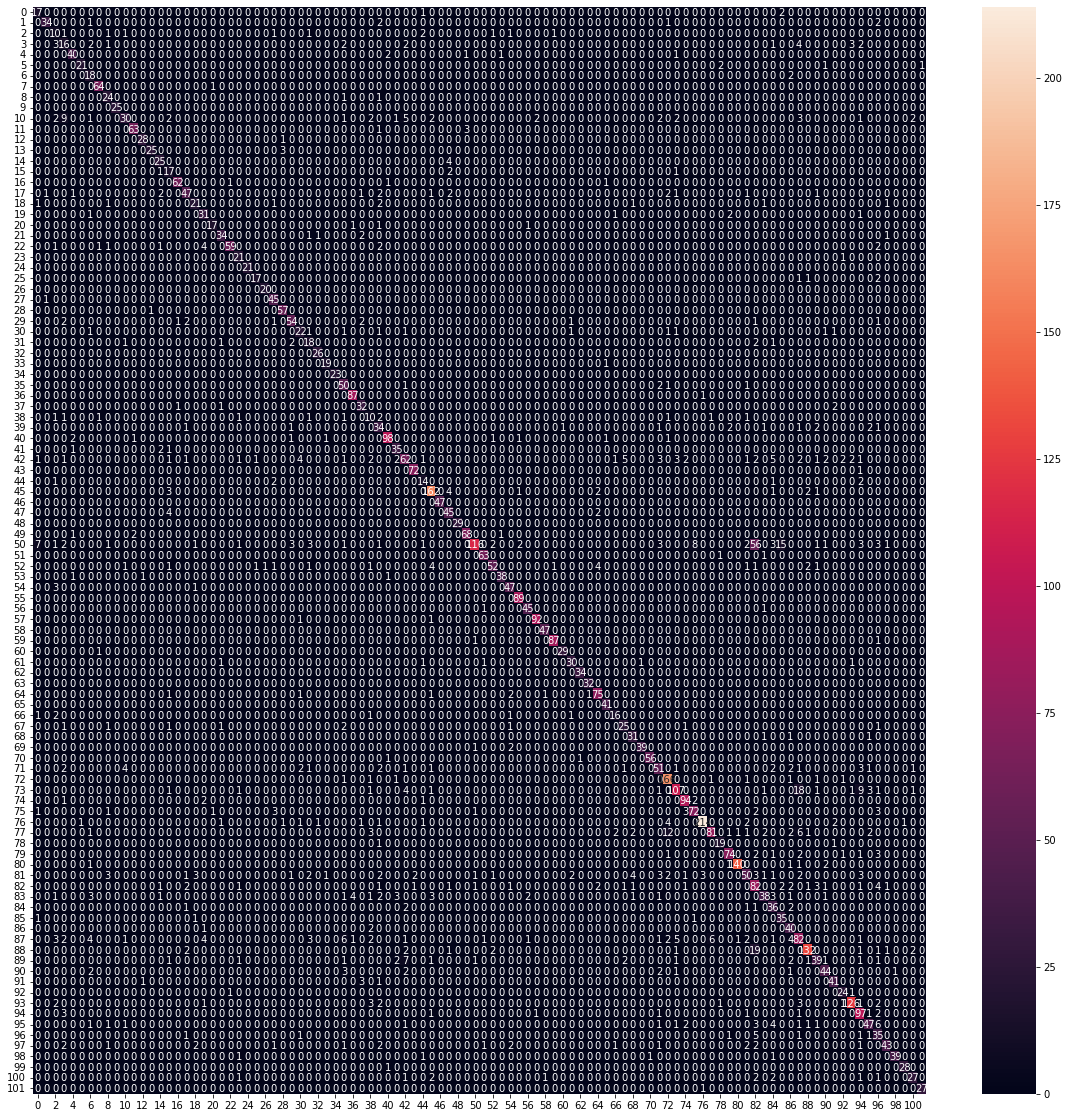

In [ ]:
import seaborn as sb
plt.figure(figsize=(20,20))
sb.heatmap(matrix, annot=True, fmt="d");

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(ytest, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(ytest, y_pred,average='micro')
print(f'Precision: {precision}')

# recall: tp / (tp + fn)
recall = recall_score(ytest, y_pred,average='micro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest, y_pred,average='micro')
print('F1 score: %f' % f1)


Accuracy: 0.834282
Precision: 0.8342819970726948
Recall: 0.834282
F1 score: 0.834282


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.85      0.69        20
           1       0.94      0.85      0.89        40
           2       0.33      0.50      0.40        20
           3       0.37      0.44      0.41        36
           4       0.87      0.89      0.88        45
           5       0.95      0.84      0.89        25
           6       0.50      0.90      0.64        20
           7       0.96      0.98      0.97        65
           8       0.67      0.92      0.77        26
           9       1.00      1.00      1.00        25
          10       0.77      0.45      0.57        67
          11       0.95      0.94      0.95        67
          12       0.93      0.97      0.95        29
          13       0.96      0.89      0.93        28
          14       0.76      0.86      0.81        29
          15       0.52      0.81      0.63        21
          16       0.97      0.95      0.96        65
          17       0.81    

In [ ]:
from google.colab import files
files.download('densenet.hdf5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Efiicient Net

In [ ]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/noisystudent/noisy_student_efficientnet-b7.tar.gz
!tar xf noisy_student_efficientnet-b7.tar.gz

In [26]:
!wget https://github.com/keras-team/keras/blob/master/keras/applications/efficientnet_weight_update_util.py

--2022-11-07 13:01:37--  https://github.com/keras-team/keras/blob/master/keras/applications/efficientnet_weight_update_util.py
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘efficientnet_weight_update_util.py’

efficientnet_weight     [ <=>                ] 287.06K  --.-KB/s    in 0.1s    

2022-11-07 13:01:38 (2.20 MB/s) - ‘efficientnet_weight_update_util.py’ saved [293952]



In [40]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*Note: Using categorical_crossentropy as it accepts one-hot encoding intead of using sparse_categorical_accuracy which accepts only label enocoding*

In [29]:
IMG_SIZE=224
def build_model(num_classes):
    inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    #x = img_augmentation(inputs)
    model = tf.keras.applications.EfficientNetB0(include_top=False, 
                                                 input_tensor=inputs,
                                                 weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = True

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["categorical_accuracy"]
    )
    return model
  
with strategy.scope():
  model = build_model(num_classes=no_classes)
model.summary()
epochs = 40  # @param {type: "slider", min:8, max:80}
# hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
# plot_hist(hist)

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                       

In [23]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [30]:
hist = model.fit(processed_train_ds, epochs=epochs, validation_data=processed_val_ds)

Epoch 1/40
32/32 [==============================] - 43s 494ms/step - loss: 7.4617 - categorical_accuracy: 0.0206 - val_loss: 1763109632.0000 - val_categorical_accuracy: 0.0098
Epoch 2/40
32/32 [==============================] - 21s 391ms/step - loss: 7.1243 - categorical_accuracy: 0.0118 - val_loss: 152310656.0000 - val_categorical_accuracy: 0.0098
Epoch 3/40
32/32 [==============================] - 22s 395ms/step - loss: 8.0380 - categorical_accuracy: 0.0137 - val_loss: 46855.1133 - val_categorical_accuracy: 0.0098
Epoch 4/40
32/32 [==============================] - 22s 399ms/step - loss: 6.3470 - categorical_accuracy: 0.0147 - val_loss: 27402500.0000 - val_categorical_accuracy: 0.0098
Epoch 5/40
32/32 [==============================] - 22s 396ms/step - loss: 6.8113 - categorical_accuracy: 0.0108 - val_loss: 8583812.0000 - val_categorical_accuracy: 0.0098
Epoch 6/40
32/32 [==============================] - 22s 399ms/step - loss: 5.5473 - categorical_accuracy: 0.0167 - val_loss: 11062.

The next step we will  unfreeze a number of layers and fit the model using smaller
learning rate. But how many layers to unfreeze is hyperparameter.

But if the feature extraction with
pretrained model works good enough, this step would give a very limited gain on
validation accuracy. In our case we only see a small improvement,
as ImageNet pretraining already exposed the model to a good amount of dogs.

On the other hand, when we use pretrained weights on a dataset that is more different
from ImageNet, this fine-tuning step can be crucial as the feature extractor also
needs to be adjusted by a considerable amount. 
According to research papers the convergence may take more than 50 epochs.

*Note on freezing/unfreezing models: setting `trainable` of a `Model` will
simultaneously set all layers belonging to the `Model` to the same `trainable`
attribute. Each layer is trainable only if both the layer itself and the model
containing it are trainable. Hence when we need to partially freeze/unfreeze
a model, we need to make sure the `trainable` attribute of the model is set
to `True`.*

In [ ]:

def unfreeze_model(model,no_layers=20):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-no_layers:]:
        if not isinstance(tf.keras.layers, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)
epochs = 10  # @param {type: "slider", min:8, max:50}


Learning rate schedule: 0.0001 to 0.0005 to 0.000102


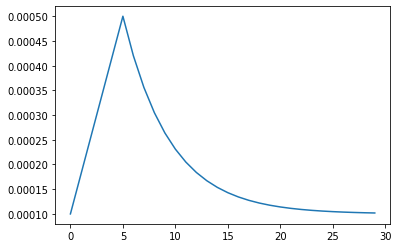

In [19]:
LR_START = 0.0001
LR_MAX = 0.0005 
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1, mode='auto', restore_best_weights=True)

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

Learning rate schedule: 0.0001 to 0.0005 to 0.000102


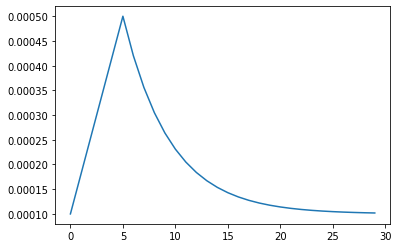

In [ ]:
LR_START = 0.0001
LR_MAX = 0.0005 
LR_MIN = 0.0001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 30
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, verbose=1, mode='auto', restore_best_weights=True)

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCHS<25 else EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [44]:
efnet.summary()
adam=tf.keras.optimizers.Adam()
efnet.compile(
optimizer=adam,
loss = 'sparse_categorical_crossentropy',
metrics=['sparse_categorical_accuracy']
)
efnet.fit(processed_train_ds, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS, callbacks=[early_stopping], validation_data=processed_val_ds)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 global_average_pooling2d_4   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 102)               261222    
                                                                 
Total params: 64,358,909
Trainable params: 261,222
Non-trainable params: 64,097,687
_________________________________________________________________
Epoch 1/40
31/31 [==============================] - 49s 860ms/step - loss: 4.9003 - sparse_categorical_accuracy: 0.0060 - val_loss: 4.7989 - val_sparse_categorical_accuracy: 0.0098
Epoch 2/40
31/31 [==============================] - 2

In [ ]:
model2.save_weights('efficientNetb7.hdf5')

### InceptionV3

In [ ]:
# DENSENET
pretrained_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False ,
                    input_shape=[224,224, 3])
pretrained_model.trainable = False # False = transfer learning, True = fine-tuning

resnet = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(no_classes, activation='softmax')

])
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
resnet.compile(optimizer=adam,loss = 'sparse_categorical_crossentropy',metrics=['accuracy'])
resnet.summary()
epochs=40

87910968/87910968 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                       

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
epochs=60
history = resnet.fit(
    processed_train_ds,
    epochs=epochs,
    validation_data=processed_val_ds,
    callbacks=[early_stopping])

Epoch 1/60
160/160 [==============================] - 80s 285ms/step - loss: 2.8632 - accuracy: 0.3775 - val_loss: 2.3716 - val_accuracy: 0.5167
Epoch 2/60
160/160 [==============================] - 61s 267ms/step - loss: 0.9812 - accuracy: 0.8063 - val_loss: 1.5785 - val_accuracy: 0.6137
Epoch 3/60
160/160 [==============================] - 64s 282ms/step - loss: 0.5335 - accuracy: 0.8947 - val_loss: 1.3496 - val_accuracy: 0.6500
Epoch 4/60
160/160 [==============================] - 62s 272ms/step - loss: 0.3362 - accuracy: 0.9431 - val_loss: 1.2480 - val_accuracy: 0.6755
Epoch 5/60
160/160 [==============================] - 62s 272ms/step - loss: 0.2323 - accuracy: 0.9675 - val_loss: 1.2079 - val_accuracy: 0.6843
Epoch 6/60
160/160 [==============================] - 61s 267ms/step - loss: 0.1693 - accuracy: 0.9776 - val_loss: 1.1650 - val_accuracy: 0.6882
Epoch 7/60
160/160 [==============================] - 62s 274ms/step - loss: 0.1386 - accuracy: 0.9780 - val_loss: 1.1356 - val_ac

In [ ]:
results = resnet.evaluate(processed_test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

193/193 [==============================] - 25s 127ms/step - loss: 1.1816 - accuracy: 0.6983
test loss, test acc: [1.1815712451934814, 0.6983249187469482]


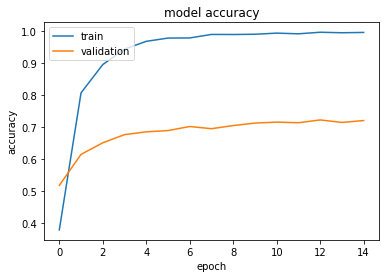

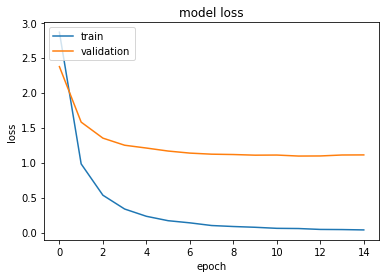

In [ ]:
# list all data in history
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
for layer in resnet.layers:
    if not isinstance(tf.keras.layers, tf.keras.layers.BatchNormalization):
            layer.trainable = True

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
inception.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

  
inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 102)              

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
epochs=20
history = inception.fit(
    processed_train_ds,
    epochs=epochs,
    validation_data=processed_val_ds,
    callbacks=[early_stopping])

Epoch 1/20
160/160 [==============================] - 99s 420ms/step - loss: 1.8579 - accuracy: 0.5269 - val_loss: 1.4383 - val_accuracy: 0.6431
Epoch 2/20
160/160 [==============================] - 87s 416ms/step - loss: 0.7845 - accuracy: 0.8063 - val_loss: 1.4323 - val_accuracy: 0.6382
Epoch 3/20
160/160 [==============================] - 83s 405ms/step - loss: 0.4503 - accuracy: 0.8965 - val_loss: 1.3022 - val_accuracy: 0.6627
Epoch 4/20
160/160 [==============================] - 83s 402ms/step - loss: 0.2829 - accuracy: 0.9400 - val_loss: 1.2096 - val_accuracy: 0.6735
Epoch 5/20
160/160 [==============================] - 83s 403ms/step - loss: 0.1908 - accuracy: 0.9602 - val_loss: 1.1272 - val_accuracy: 0.7010
Epoch 6/20
160/160 [==============================] - 85s 411ms/step - loss: 0.1424 - accuracy: 0.9704 - val_loss: 1.0838 - val_accuracy: 0.7098
Epoch 7/20
160/160 [==============================] - 84s 409ms/step - loss: 0.1121 - accuracy: 0.9804 - val_loss: 1.0541 - val_ac

In [ ]:
results = inception.evaluate(processed_test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

193/193 [==============================] - 22s 111ms/step - loss: 1.0392 - accuracy: 0.7544
test loss, test acc: [1.0392488241195679, 0.7544316053390503]


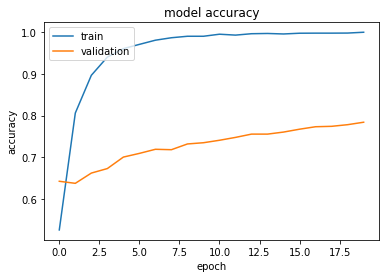

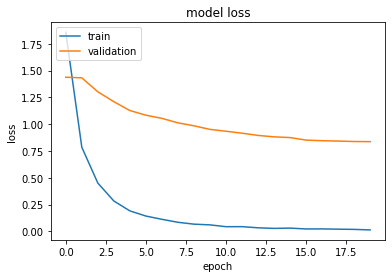

In [ ]:
# list all data in history
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## WITHOUT AUGMENTATION

In [44]:
buffer_size=2048
batch_size=32
processed_train_ds = train_ds.map(lambda x : preprocess_data(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
processed_val_ds = val_ds.map(lambda x: preprocess_data(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)
processed_test_ds = test_ds.map(lambda x: preprocess_data(x,encode=False),num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size)

In [49]:
# DENSENET
pretrained_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False ,
                    input_shape=[224,224, 3])
pretrained_model.trainable = False # False = transfer learning, True = fine-tuning

densenet = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(no_classes, activation='softmax')
])
    

densenet.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_5   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 102)               195942    
                                                                 
Total params: 18,517,926
Trainable params: 195,942
Non-trainable params: 18,321,984
_________________________________________________________________


In [50]:
# Training all layers
EPOCHS=40
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3,min_delta=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
densenet.compile(optimizer=adam,loss = 'sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])
history_no_augmentation = densenet.fit(processed_train_ds, epochs=EPOCHS, callbacks=[early_stopping,lr_callback], validation_data=processed_val_ds)


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/40
32/32 [==============================] - 25s 383ms/step - loss: 4.8758 - sparse_categorical_accuracy: 0.0059 - val_loss: 4.7150 - val_sparse_categorical_accuracy: 0.0098 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.00018.
Epoch 2/40
32/32 [==============================] - 12s 295ms/step - loss: 4.5326 - sparse_categorical_accuracy: 0.0304 - val_loss: 4.4008 - val_sparse_categorical_accuracy: 0.0422 - lr: 1.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00026000000000000003.
Epoch 3/40
32/32 [==============================] - 12s 298ms/step - loss: 4.1471 - sparse_categorical_accuracy: 0.1098 - val_loss: 4.0346 - val_sparse_categorical_accuracy: 0.1588 - lr: 2.6000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00034.
Epoch 4/40
32/32 [==============================] - 13s 320ms/step - loss: 3.6663 - sparse_categorical_accuracy: 0.2922 - val_lo

In [51]:
results = densenet.evaluate(processed_test_ds, batch_size=batch_size)
print("test loss, test acc:", results)

193/193 [==============================] - 28s 146ms/step - loss: 1.2183 - sparse_categorical_accuracy: 0.8153
test loss, test acc: [1.2183173894882202, 0.8152545094490051]


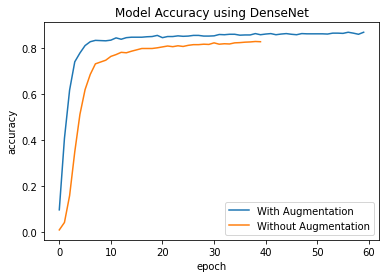

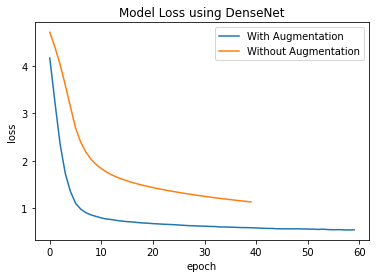

In [52]:
# list all data in history
# summarize history for accuracy
plt.plot(history_densenet.history['val_sparse_categorical_accuracy'])
plt.plot(history_no_augmentation.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy using DenseNet')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['With Augmentation', 'Without Augmentation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history_densenet.history['val_loss'])
plt.plot(history_no_augmentation.history['val_loss'])
plt.title('Model Loss using DenseNet')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['With Augmentation', 'Without Augmentation'], loc='upper right')
plt.show()